<a href="https://colab.research.google.com/github/DariMe20/SocialNetworkAnalysis/blob/main/SNA_trafic_application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analyzing Urban Traffic Networks using SNA: Cluj Napoca road system**

This project analyzes the road network of Cluj-Napoca using Social Network Analysis (SNA) techniques.

It explores the network's structure by calculating and visualizing **centrality measures** (degree, closeness, and betweenness) to identify important intersections and potential traffic bottlenecks.

The project also applies **community detection algorithms** to uncover structural divisions within the network and compares these with official administrative neighborhoods.

## **Install and import libraries**
Install osmnx (to get real city graphs) and import common SNA tools.

In [1]:
!pip install osmnx networkx matplotlib pandas --quiet

In [2]:
# --- Imports ---
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Configure OSMnx settings (smaller figures, white background)
ox.settings.log_console = True
ox.settings.use_cache = True
ox.settings.default_graph_boundary = "city"

## **Build Road Graph for Cluj Napoca**

We start by downloading the raw street network of Cluj-Napoca using OSMnx.

**Each node** represents a street intersection or dead end, and each **edge** is a drivable road segment.

`osmnx` downloads OpenStreetMap data and builds a directed weighted graph of roads.

`Nodes = intersections, Edges = drivable road segments.`

###**Cluj Napoca raw road network**

This plot shows the raw road network of Cluj-Napoca as a graph. The blue points represent intersections (nodes), and the light gray lines represent the road segments (edges). You can see the structure and density of the street network across the city.

Raw graph: 3244 nodes, 7313 edges


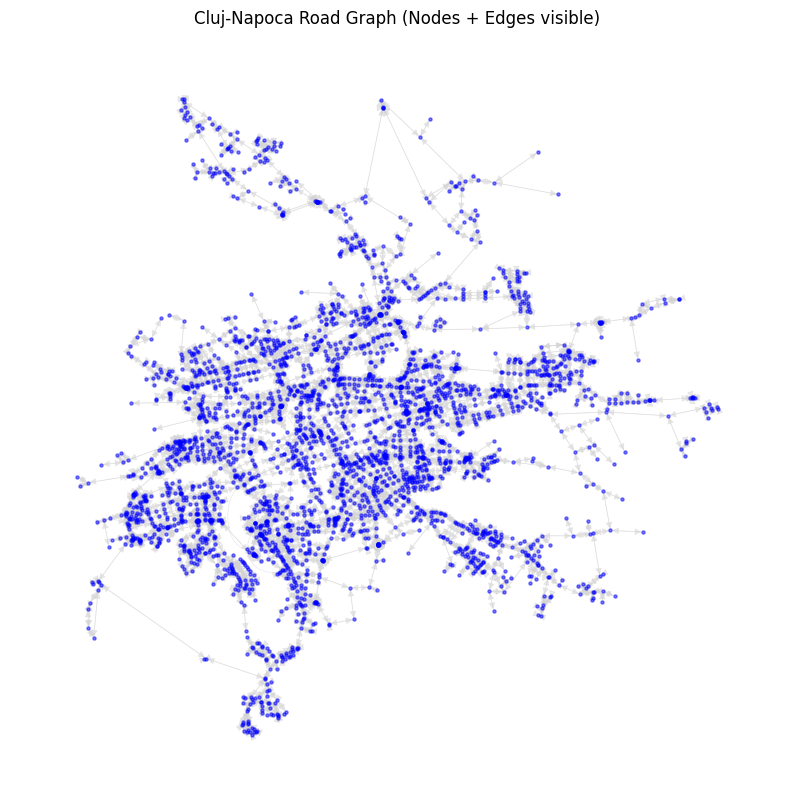

In [15]:
# Create graph with all drivable roads
city = "Cluj-Napoca, Romania"
G = ox.graph_from_place(city, network_type="drive", simplify=True)

print("Raw graph:", len(G.nodes()), "nodes,", len(G.edges()), "edges")

# Draw with visible nodes and edges
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(
    G,
    pos={n: (d["x"], d["y"]) for n, d in G.nodes(data=True)},
    node_size=5,
    node_color="blue",
    edge_color="lightgray",
    width=0.5,
    alpha=0.5,
)
plt.title("Cluj-Napoca Road Graph (Nodes + Edges visible)")
plt.show()

## **Explore node degree distribution**

Let's see how many streets meet at each intersection.

This code calculates the **degree of each node (intersection)** in the graph and then visualizes the distribution of these degrees using a histogram.

**The degree of a node** is the number of edges connected to it, representing the number of roads meeting at that intersection. The histogram shows how frequently different degrees occur in the network. You can see how common it is for intersections to have 2, 3, 4, or more connected roads.

**Most intersections connect 3-4 streets**, which is typical for urban road networks.

**High-degree nodes** represent major traffic hubs where a larger number of roads converge.

**The average node degree** provides a summary statistic of the network's overall connectivity.

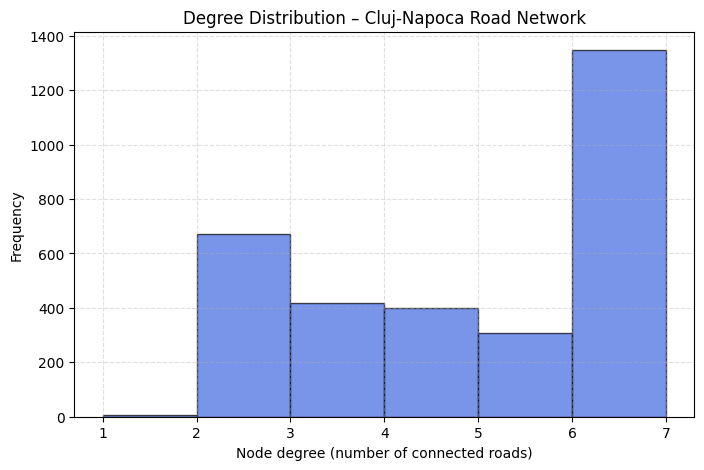

Average node degree: 4.51


In [16]:
degrees = [val for (node, val) in G.degree()]

plt.figure(figsize=(8, 5))
plt.hist(degrees, bins=range(1, 8), color="royalblue", edgecolor="black", alpha=0.7)
plt.xlabel("Node degree (number of connected roads)")
plt.ylabel("Frequency")
plt.title("Degree Distribution – Cluj-Napoca Road Network")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

print("Average node degree:", np.mean(degrees).round(2))


## **Compute centrality measures**

We now calculate three key centrality measures to understand the importance of different intersections (nodes) in the road network:

**Degree centrality:** Measures the number of direct connections an intersection has. It indicates `local connectivity` - how many roads meet at that point.

**Closeness centrality:** Measures how easily reachable an intersection is from all other intersections in the network. It indicates `accessibility` - nodes with high closeness can quickly connect to the rest of the network.

**Betweenness centrality:** Measures how often an intersection lies on the shortest path between other pairs of intersections. It indicates `potential bottlenecks` - nodes with high betweenness are critical for traffic flow between different parts of the network.

In [17]:
deg_c = nx.degree_centrality(G)
clo_c = nx.closeness_centrality(G)
bet_c = nx.betweenness_centrality(G, k=500, normalized=True, endpoints=False)

print("Centrality metrics computed for", len(G.nodes()), "intersections.")


Centrality metrics computed for 3244 intersections.


## **Visualize centralities**

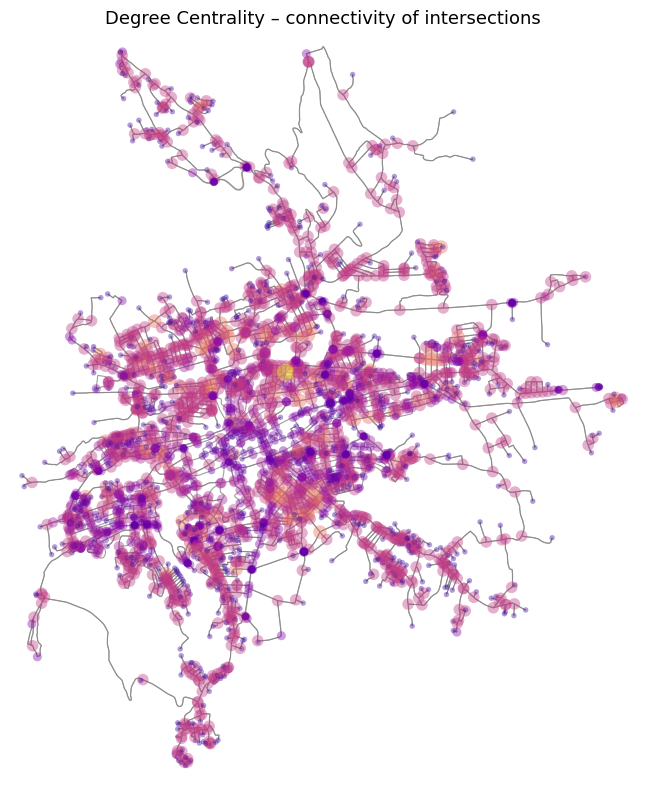

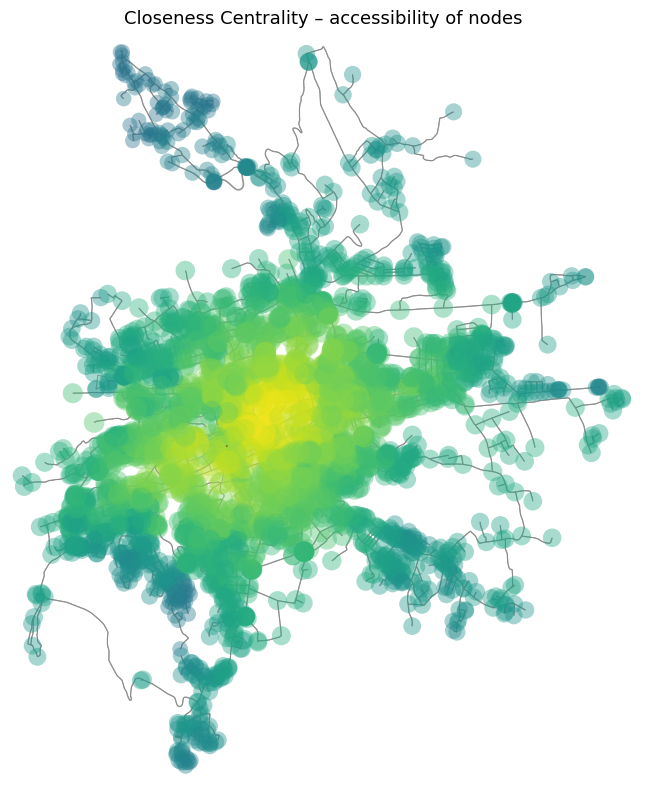

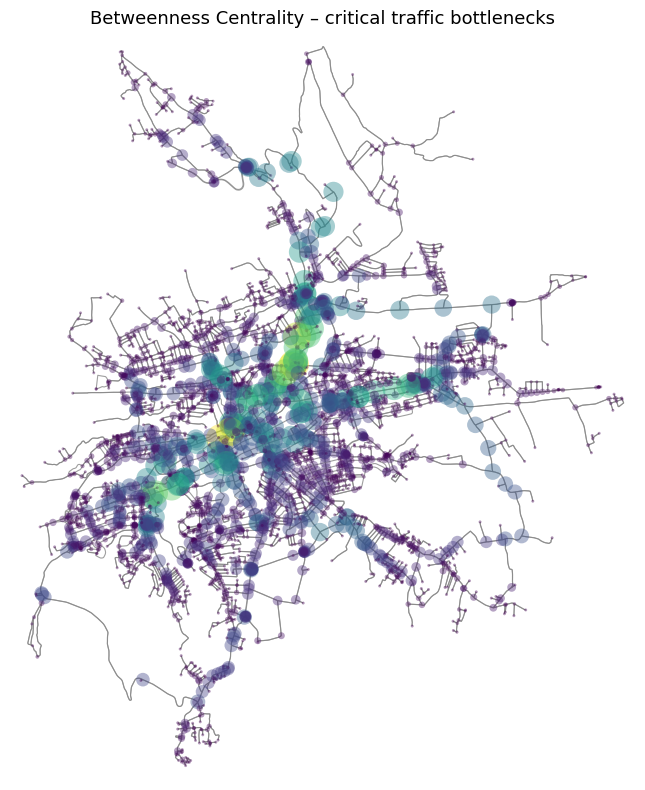

In [83]:
import matplotlib.pyplot as plt
import numpy as np

def plot_centrality(G, values, title, scale=1.0, cmap_name="plasma"):
    v = np.array(list(values.values()))
    v_norm = (v - v.min()) / (v.max() - v.min() + 1e-9)

    cmap = plt.colormaps[cmap_name]
    node_color = [cmap(x) for x in v_norm]
    node_size = ((v_norm + 0.01) * 150 * scale).tolist()

    fig, ax = ox.plot_graph(
        G,
        node_color=node_color,
        node_size=node_size,
        node_alpha=0.4,
        edge_color="#888888",
        edge_linewidth=0.8,
        edge_alpha=0.8,
        bgcolor="white",
        show=False,
        close=False
    )

    plt.title(title, fontsize=13)
    plt.tight_layout()
    plt.show()

plot_centrality(G, deg_c, "Degree Centrality – connectivity of intersections", scale=1.0, cmap_name="plasma")
plot_centrality(G, clo_c, "Closeness Centrality – accessibility of nodes", scale=2.0, cmap_name="viridis")
plot_centrality(G, bet_c, "Betweenness Centrality – critical traffic bottlenecks", scale=3.0, cmap_name="viridis")



In [ ]:
da Paris

### **Top 10 Most Central Intersections - Table**

This section identifies and presents the top 10 intersections with the `highest betweenness centrality in Cluj-Napoca`.

**Betweenness centrality** measures how often a node lies on the shortest path between other nodes, indicating its potential as a traffic bottleneck.

The table displays the `node ID, degree, closeness, and betweenness centrality` for these top intersections, along with the names of the streets connected to each node.

The intersections listed in this table, often located on major roads like Strada Paris, Dorobanților, or 21 Decembrie, are crucial points in the city's road network where traffic is likely to be most concentrated and where disruptions could have significant impacts on overall flow.

In [159]:
df = pd.DataFrame({
    "node": list(G.nodes()),
    "degree": [deg_c[n] for n in G.nodes()],
    "closeness": [clo_c[n] for n in G.nodes()],
    "betweenness": [bet_c[n] for n in G.nodes()],
})

top10 = df.sort_values("betweenness", ascending=False).head(10)

# Get street names connected to the top nodes
street_names = {}
for node in top10['node']:
    connected_streets = set()
    for u, v, data in G.edges(node, data=True):
        if 'name' in data:
            # Handle cases where 'name' is a list or a single string
            if isinstance(data['name'], list):
                for name in data['name']:
                    connected_streets.add(name)
            else:
                connected_streets.add(data['name'])
    street_names[node] = list(connected_streets)

top10['connected_streets'] = top10['node'].map(street_names)

display(top10)

node    degree  closeness  betweenness  \
253   277101977  0.001850   0.031855     0.176961   
34     59667716  0.001850   0.033253     0.176337   
525   341311509  0.002467   0.032131     0.164780   
1234  507121927  0.001233   0.033605     0.161356   
882   353771176  0.002467   0.029395     0.159799   
31     59666047  0.001850   0.033822     0.145428   
1303  654023658  0.003700   0.032584     0.144237   
876   353771051  0.001850   0.028840     0.135440   
71    122984728  0.002467   0.028136     0.133473   
70    122984718  0.001850   0.029184     0.132634   

                                      connected_streets  
253                         [Piața 1 Mai, Strada Paris]  
34    [Splaiul Independenței, Strada George Barițiu,...  
525                  [Strada Răsăritului, Strada Paris]  
1234                            [Strada George Barițiu]  
882   [Strada Nădășel, Strada Alexandru Sahia, Podul...  
31    [Strada George Barițiu, Strada Horea, Strada R...  
1303  [Strada Olănești, Strada Meseriilor, Strada Pa...  
876                     [Strada Nădășel, Strada Ovidiu]  
71      [Strada Govora, Calea Mănăștur, Strada Tarnița]  
70                    [Calea Mănăștur, Strada Berăriei]

from matplotlib import pyplot as plt
top10['node'].plot(kind='hist', bins=20, title='node')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
top10['degree'].plot(kind='hist', bins=20, title='degree')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
top10['closeness'].plot(kind='hist', bins=20, title='closeness')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
top10['betweenness'].plot(kind='hist', bins=20, title='betweenness')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
top10.plot(kind='scatter', x='node', y='degree', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
top10.plot(kind='scatter', x='degree', y='closeness', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
top10.plot(kind='scatter', x='closeness', y='betweenness', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
top10['node'].plot(kind='line', figsize=(8, 4), title='node')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
top10['degree'].plot(kind='line', figsize=(8, 4), title='degree')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
top10['closeness'].plot(kind='line', figsize=(8, 4), title='closeness')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
top10['betweenness'].plot(kind='line', figsize=(8, 4), title='betweenness')
plt.gca().spines[['top', 'right']].set_visible(False)

## **Top 10 Most Central Intersections and Connected Roads (Subgraph Visualization)**

This section visualizes the areas around the top 10 most central intersections for Degree, Closeness, and Betweenness centrality.

Instead of showing the whole city, it focuses on a subgraph that includes the top nodes and all nodes reachable within a specified number of "hops" (steps) in the network.

Each plot shows:

*   The road network within the subgraph.
*   `Red circles`: Highlight the top 10 most central nodes for that specific centrality measure.
*   `Blue lines`: Represent the roads directly connected to these highlighted top nodes.
*   `Labels`: Show the names of the streets connected to the top nodes.

**Interpretation:**

By examining these plots, you can see the spatial distribution of the most important intersections based on different criteria:

*   **Degree Centrality:** Highlights intersections that are local hubs with many direct connections.
*   **Closeness Centrality:** Shows intersections that are topologically close to many other nodes within their neighborhood (defined by hops).
*   **Betweenness Centrality:** Identifies intersections that are critical connectors within their neighborhood, likely carrying significant flow between different parts of the subgraph.


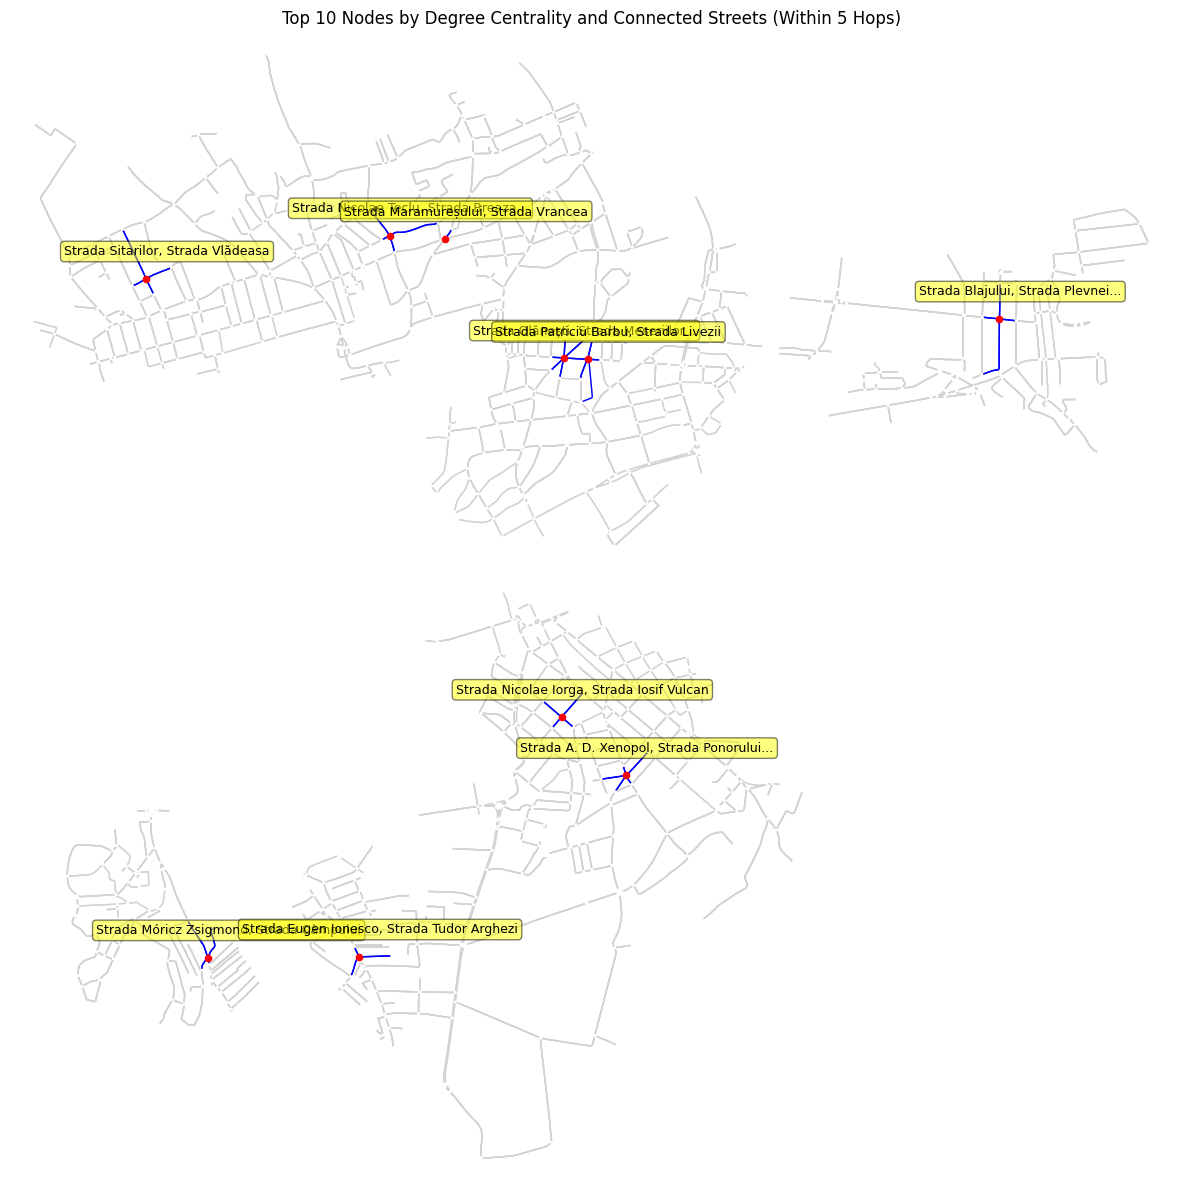

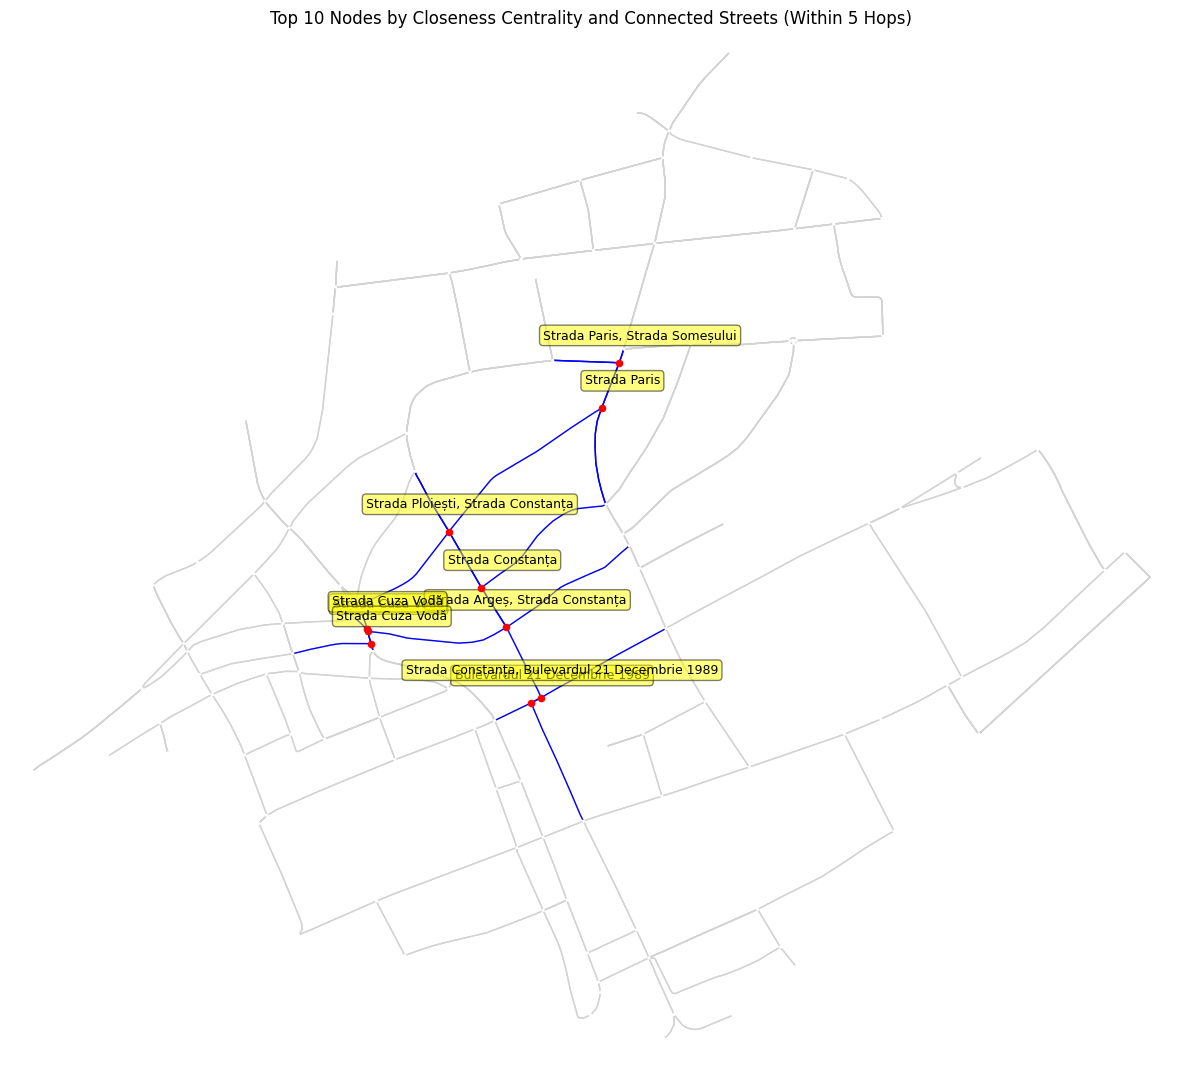

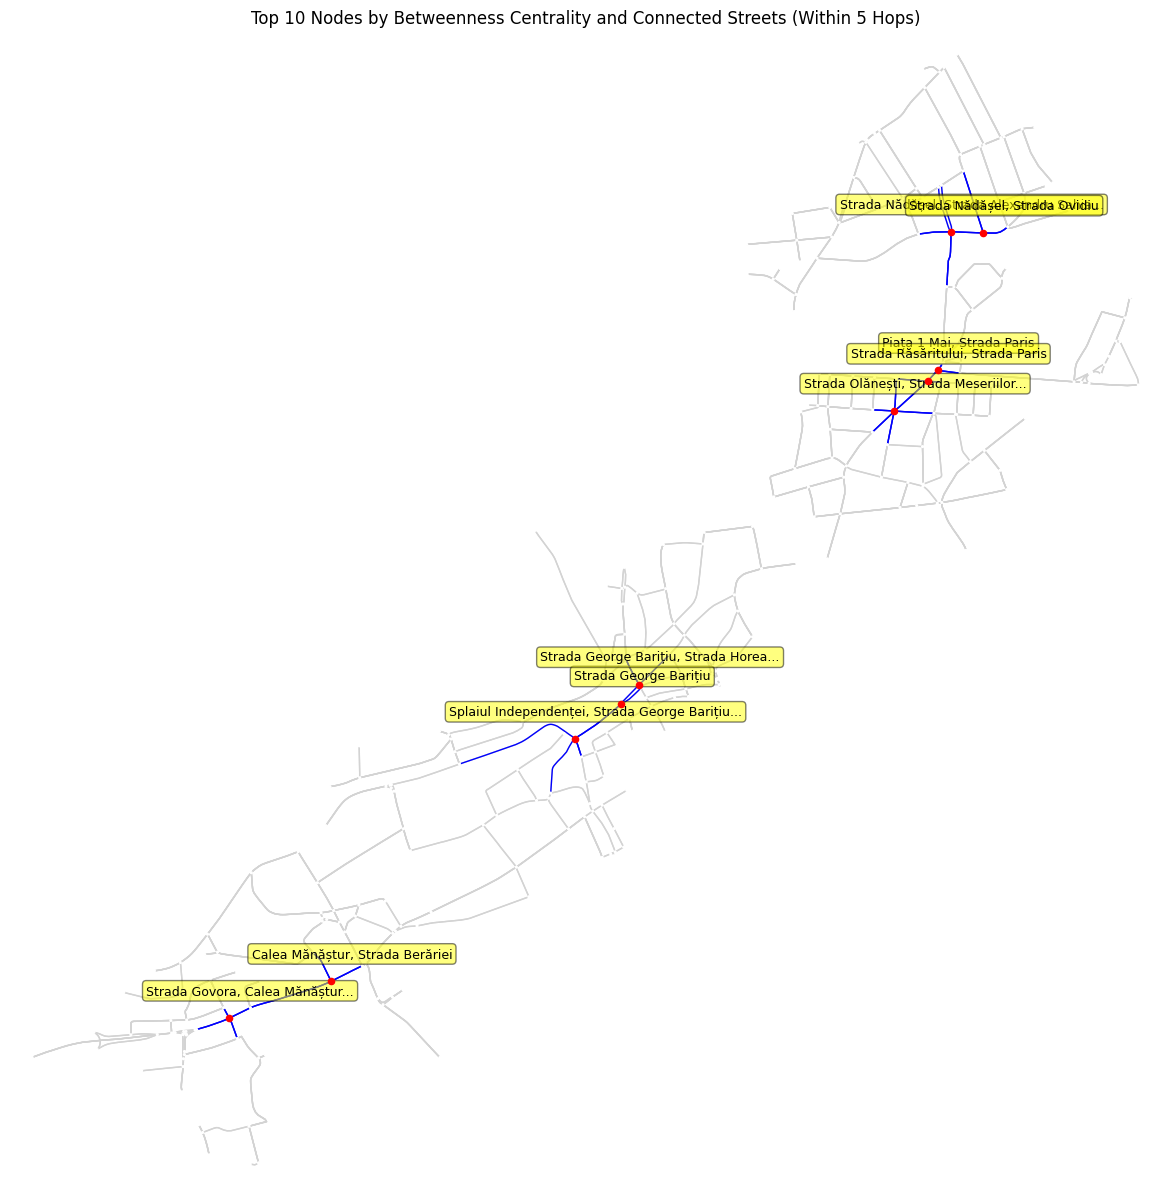

In [134]:
def visualize_top_nodes_with_streets_subgraph(G, top_nodes_df, title, hops=2):
    top_node_ids = top_nodes_df['node'].tolist()
    top_nodes_info = top_nodes_df.set_index('node')['connected_streets'].to_dict()

    # Get nodes within the specified number of hops from the top nodes
    subgraph_nodes = set(top_node_ids)
    for start_node in top_node_ids:
        try:
            reachable_nodes = nx.single_source_shortest_path_length(G.to_undirected(), start_node, cutoff=hops)
            subgraph_nodes.update(reachable_nodes.keys())
        except nx.NetworkXNoPath:
             # Handle cases where a node might be isolated or not reachable within hops
             pass

    # Create a subgraph containing the identified nodes and all edges between them
    subgraph = G.subgraph(list(subgraph_nodes))

    # Get the coordinates of the nodes in the subgraph for labeling
    node_xy_subgraph = {node: (subgraph.nodes[node]['x'], subgraph.nodes[node]['y']) for node in subgraph.nodes()}


    # Create a basemap of the subgraph with slightly visible general nodes
    fig, ax = ox.plot_graph(subgraph, node_size=5, edge_color="lightgray", bgcolor="white",
                            show=False, close=False, figsize=(15, 15), edge_linewidth=1.0)

    # Highlight the original top nodes and add labels within the subgraph plot
    for node, streets in top_nodes_info.items():
        if node in subgraph.nodes(): # Ensure node is in the extracted subgraph
            x, y = node_xy_subgraph[node]
            ax.scatter(x, y, s=20, c='red', zorder=5)

            # Add labels with connected street names (handling multiple names and potential overlap)
            label_text = ", ".join(streets[:2]) + ("..." if len(streets) > 2 else "") # Limit to 2 street names
            ax.annotate(label_text, (x, y), textcoords="offset points", xytext=(15, 15),
                        ha='center', va='bottom', fontsize=9,
                        bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.5)) # Add bbox for readability


    # Color edges connected to original top nodes in blue within the subgraph
    edge_colors = []
    for u, v, key, data in subgraph.edges(keys=True, data=True): # Iterate through edges of the subgraph
        if u in top_node_ids or v in top_node_ids:
            edge_colors.append("blue")
        else:
            edge_colors.append("lightgray")

    # Re-plot edges with updated colors on the same axes
    ox.plot_graph(subgraph, node_size=5, edge_color=edge_colors, bgcolor="white",
                  show=False, close=False, figsize=(15, 15), edge_linewidth=1.0, ax=ax)


    plt.title(title)
    plt.show()

# Visualize top 10 nodes for each centrality measure on a subgraph within x hops
visualize_top_nodes_with_streets_subgraph(G, top10_degree, "Top 10 Nodes by Degree Centrality and Connected Streets (Within 10 Hops)", hops=10)
visualize_top_nodes_with_streets_subgraph(G, top10_closeness, "Top 10 Nodes by Closeness Centrality and Connected Streets (Within 5 Hops)", hops=5)
visualize_top_nodes_with_streets_subgraph(G, top10_betweenness, "Top 10 Nodes by Betweenness Centrality and Connected Streets (Within 5 Hops)", hops=5)

## **Centrality Correlations**

This section calculates and visualizes the correlations between the three centrality measures:` Degree, Closeness, and Betweenness Centrality.`

The correlation coefficients indicate how strongly related each pair of measures is (a value closer to 1 or -1 means a stronger relationship, while a value closer to 0 means a weaker relationship). The scatter plots visually show this relationship.

**Interpretation:**

*   **Degree-Closeness:** The correlation value and scatter plot show a relatively `weak positive relationship`. This suggests that while intersections with more connected roads (higher degree) tend to be slightly more accessible (higher closeness), it's not a strong direct link.

*   **Betweenness-Closeness:** This shows a `moderate positive correlation`. Intersections that are more accessible (higher closeness) are also more likely to lie on shortest paths between other intersections (higher betweenness).

*   **Degree-Betweenness:** There's a `weak positive correlation here`. Intersections with many connected roads (higher degree) have a slight tendency to also be important connectors on shortest paths (higher betweenness), but this relationship is not very strong in this network.


Degree–Closeness: 0.143
Betweenness–Closeness: 0.376
Degree–Betweenness: 0.263


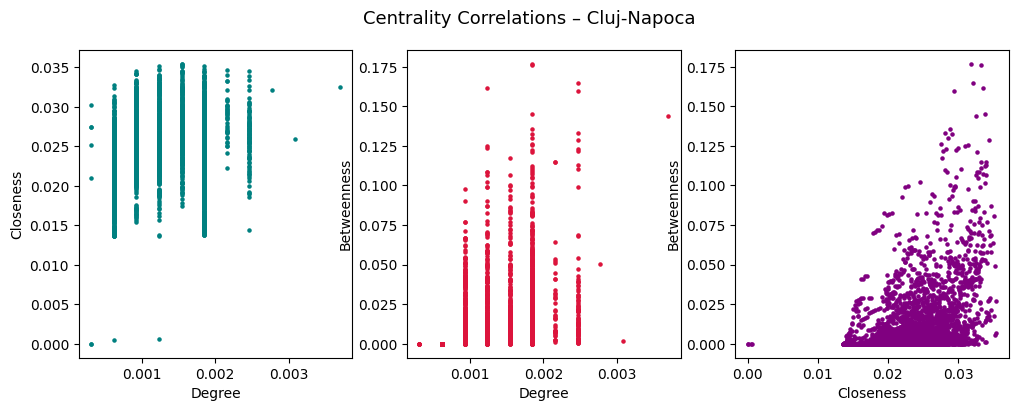

In [84]:
corr_deg_clo = pearsonr(df["degree"], df["closeness"])[0]
corr_bet_clo = pearsonr(df["betweenness"], df["closeness"])[0]
corr_deg_bet = pearsonr(df["degree"], df["betweenness"])[0]

print(f"Degree–Closeness: {corr_deg_clo:.3f}")
print(f"Betweenness–Closeness: {corr_bet_clo:.3f}")
print(f"Degree–Betweenness: {corr_deg_bet:.3f}")

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.scatter(df["degree"], df["closeness"], s=5, color="teal"); plt.xlabel("Degree"); plt.ylabel("Closeness")
plt.subplot(1,3,2); plt.scatter(df["degree"], df["betweenness"], s=5, color="crimson"); plt.xlabel("Degree"); plt.ylabel("Betweenness")
plt.subplot(1,3,3); plt.scatter(df["closeness"], df["betweenness"], s=5, color="purple"); plt.xlabel("Closeness"); plt.ylabel("Betweenness")
plt.suptitle("Centrality Correlations – Cluj-Napoca", fontsize=13)
plt.show()


## **Analysis of Cluj Napoca City Center**

This section focuses on analyzing the road network within a 2 km radius of the Cluj-Napoca city center to understand the characteristics and importance of intersections in this core urban area.

The code extracts a subgraph representing the city center and then visualizes its structure and centrality measures.

**Interpretation:**

*   **Simple graph city center:** This initial plot shows the road network within the 2 km radius, with red dots representing intersections and gray lines representing roads.

*   **Degree Centrality - connectivity of intersections:** This plot illustrates how many roads meet at each intersection across the city center.

*   **Betweenness Centrality - Cluj City Center:** This plot highlights the intersections within the city center that are critical for connecting other parts of the network. Brighter and larger nodes indicate intersections that lie on many shortest paths and are likely to experience high traffic flow and potential bottlenecks within the central area.

*   **Closeness Centrality - accessibility of nodes:** This plot shows how easily reachable each intersection is from all other intersections within the city center subgraph. Brighter and larger nodes represent intersections that are most accessible within the central area.


Subgraph (city center): 443 nodes, 940 edges


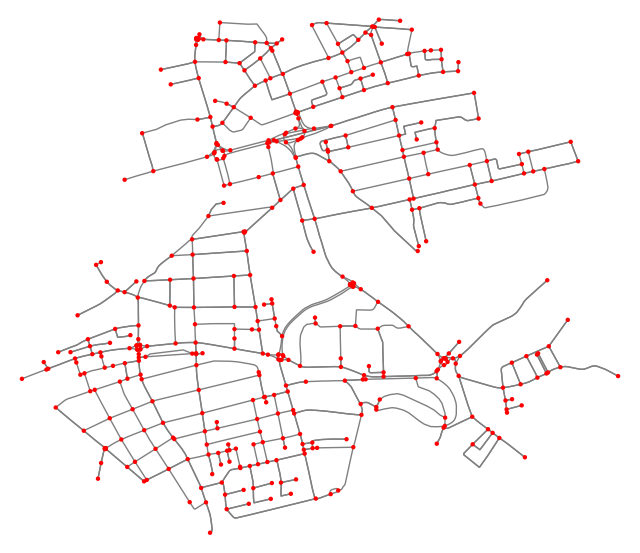

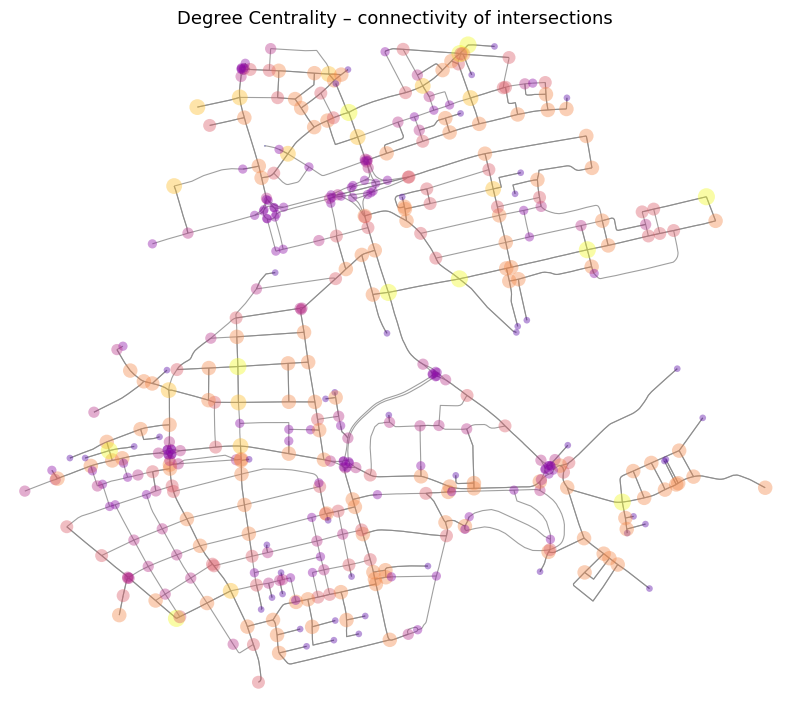

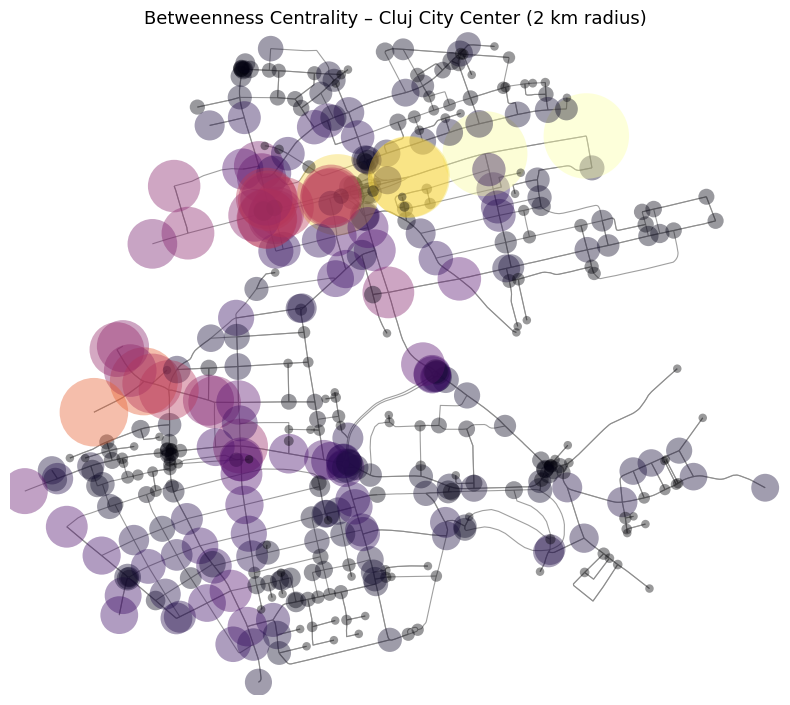

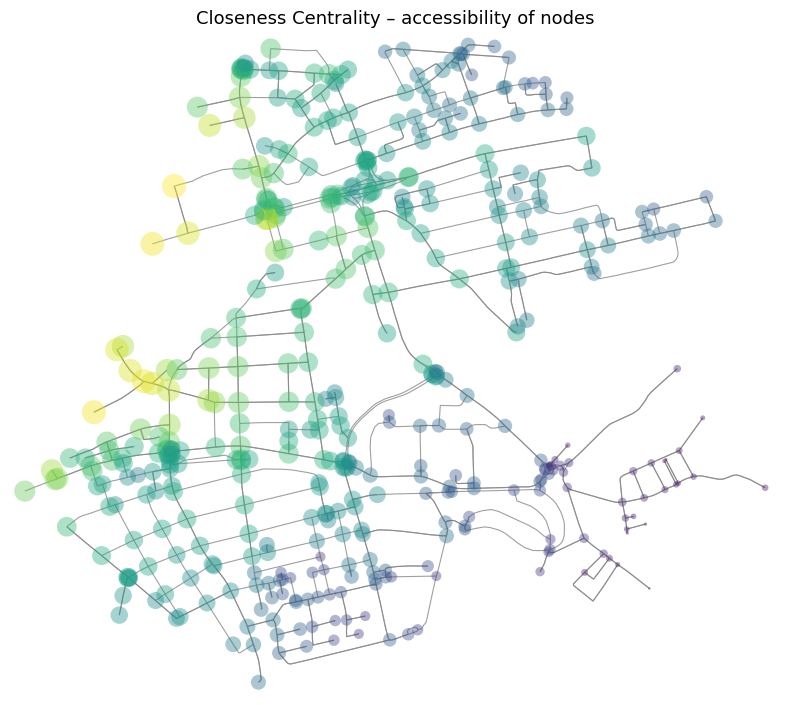

In [103]:
center_point = (46.7712, 23.6236)  # latitude, longitude

# Find nearest node to these coordinates
center_node = ox.distance.nearest_nodes(G, X=center_point[1], Y=center_point[0])

# Extract subgraph within 2 km radius (OSMnx >= 2.x)
subG = ox.truncate.truncate_graph_dist(G, center_node, dist=2000)

print("Subgraph (city center):", len(subG.nodes()), "nodes,", len(subG.edges()), "edges")

# Plot the simple subgraph with small red nodes
fig, ax = ox.plot_graph(subG, node_size=10, node_color='red', edge_color='gray', bgcolor='white')


# Filter betweenness centrality values for the nodes in the subgraph
subG_bet_c = {n: bet_c[n] for n in subG.nodes()}

# Filter closeness centrality values for the nodes in the subgraph
subG_clo_c = {n: clo_c[n] for n in subG.nodes()}

# Filter degree centrality values for the nodes in the subgraph
subG_deg_c = {n: deg_c[n] for n in subG.nodes()}

# Plot degree centrality for central Cluj
plot_centrality(subG, subG_deg_c, "Degree Centrality – connectivity of intersections", scale=1.0, cmap_name="plasma")

# Plot betweenness centrality for central Cluj
plot_centrality(subG, subG_bet_c, "Betweenness Centrality – Cluj City Center (2 km radius)", scale=25.0, cmap_name="inferno")

# Plot closeness centrality for central Cluj
plot_centrality(subG, subG_clo_c, "Closeness Centrality – accessibility of nodes", scale=2.0, cmap_name="viridis")



## **Detected Road Network Communities**

This section applies three different community detection algorithms (**Greedy Modularity, Label Propagation, and Louvain**) to the Cluj-Napoca road network and visualizes the results.

Each plot shows the city's road network with nodes colored according to the community they belong to, as identified by each algorithm.


*   **Greedy Modularity:** This algorithm iteratively merges nodes or groups of nodes to maximize the "modularity" of the network, a measure of how well the network is partitioned into communities.
*   **Label Propagation:** Starting with each node having a unique label, nodes iteratively adopt the most frequent label among their neighbors, causing labels to propagate and nodes within the same community to converge on the same label.
*   **Louvain Method:** A hierarchical algorithm that optimizes modularity in two phases: moving nodes to neighboring communities and then building a new network from the detected communities, repeating until modularity is maximized.

**Differences between the methods:**

*   **Number of Communities:** The three algorithms often detect a different number of communities. `Label Propagation` typically finds many smaller communities, while `Greedy Modularity` and `Louvain` tend to find fewer, larger communities.
*   **Community Structure:** The specific boundaries and membership of the communities can vary between the algorithms due to their different approaches to community detection.

Greedy communities: 38
Label propagation: 1010
Louvain communities: 39


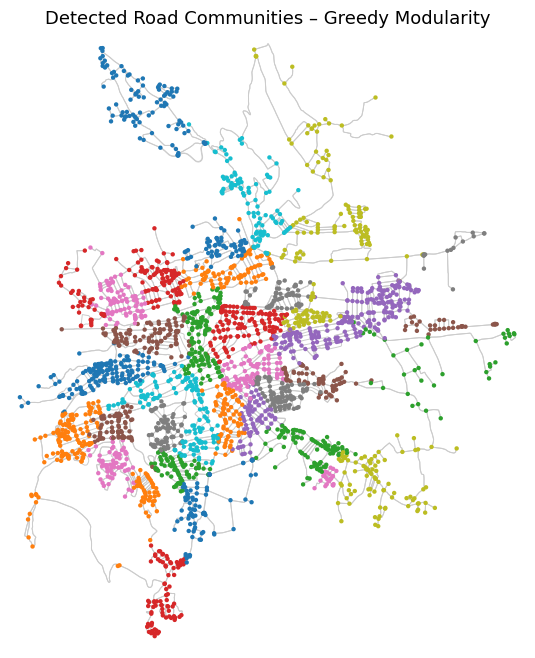

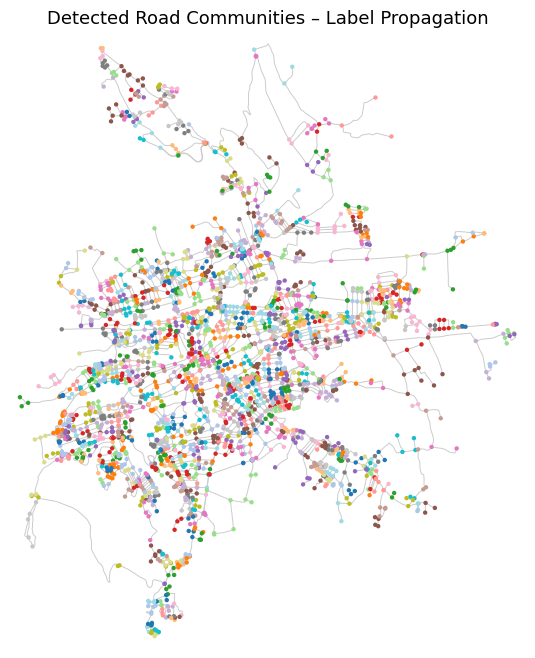

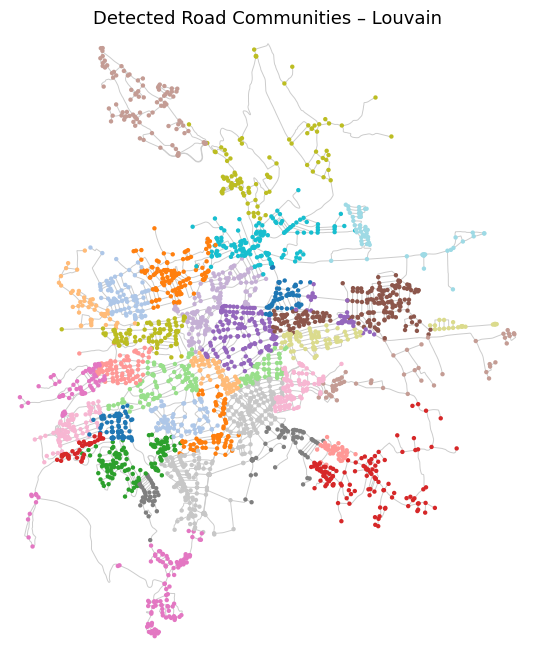

In [145]:
import networkx.algorithms.community as nx_comm
import community as community_louvain  # pip install python-louvain
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# --- different community detection algorithms ---
greedy = list(nx_comm.greedy_modularity_communities(G))
# Convert G to undirected for Label Propagation as it's typically used with undirected graphs
G_undirected = G.to_undirected()
labelp = list(nx_comm.asyn_lpa_communities(G_undirected, weight=None)) # Use undirected graph for label propagation
louvain_part = community_louvain.best_partition(G_undirected) # Use undirected graph for Louvain


print("Greedy communities:", len(greedy))
print("Label propagation:", len(labelp))
print("Louvain communities:", len(set(louvain_part.values())))

# --- Plotting Communities ---

# Plotting Greedy Modularity Communities
community_map_greedy = {}
for i, c in enumerate(greedy):
    for node in c:
        community_map_greedy[node] = i

cmap_greedy = plt.colormaps["tab10"]
node_color_greedy = [cmap_greedy(community_map_greedy[n] % 10) for n in G.nodes()]

ox.plot_graph(
    G, # Use original directed graph for plotting if desired, or undirected G_undirected
    node_color=node_color_greedy,
    node_size=10,
    edge_color="#cccccc",
    edge_linewidth=0.7,
    bgcolor="white",
    show=False,
    close=False
)
plt.title("Detected Road Communities – Greedy Modularity", fontsize=13)
plt.show()


# Plotting Label Propagation Communities
community_map_labelp = {}
for i, c in enumerate(labelp):
    for node in c:
        community_map_labelp[node] = i

cmap_labelp = plt.colormaps["tab20"] if len(labelp) > 10 else plt.colormaps["tab10"]
node_color_labelp = [cmap_labelp(community_map_labelp[n] % cmap_labelp.N) for n in G_undirected.nodes()] # Use G_undirected for plotting as labelp was computed on it

ox.plot_graph(
    G_undirected, # Plot the undirected graph
    node_color=node_color_labelp,
    node_size=10,
    edge_color="#cccccc",
    edge_linewidth=0.7,
    bgcolor="white",
    show=False,
    close=False
)
plt.title("Detected Road Communities – Label Propagation", fontsize=13)
plt.show()


# Plotting Louvain Communities
community_map_louvain = louvain_part # louvain_part is already a node-community ID map

cmap_louvain = plt.colormaps["tab20"] if len(set(louvain_part.values())) > 10 else plt.colormaps["tab10"]
node_color_louvain = [cmap_louvain(community_map_louvain[n] % cmap_louvain.N) for n in G_undirected.nodes()] # Use G_undirected for plotting

ox.plot_graph(
    G_undirected, # Plot the undirected graph
    node_color=node_color_louvain,
    node_size=10,
    edge_color="#cccccc",
    edge_linewidth=0.7,
    bgcolor="white",
    show=False,
    close=False
)
plt.title("Detected Road Communities – Louvain", fontsize=13)
plt.show()

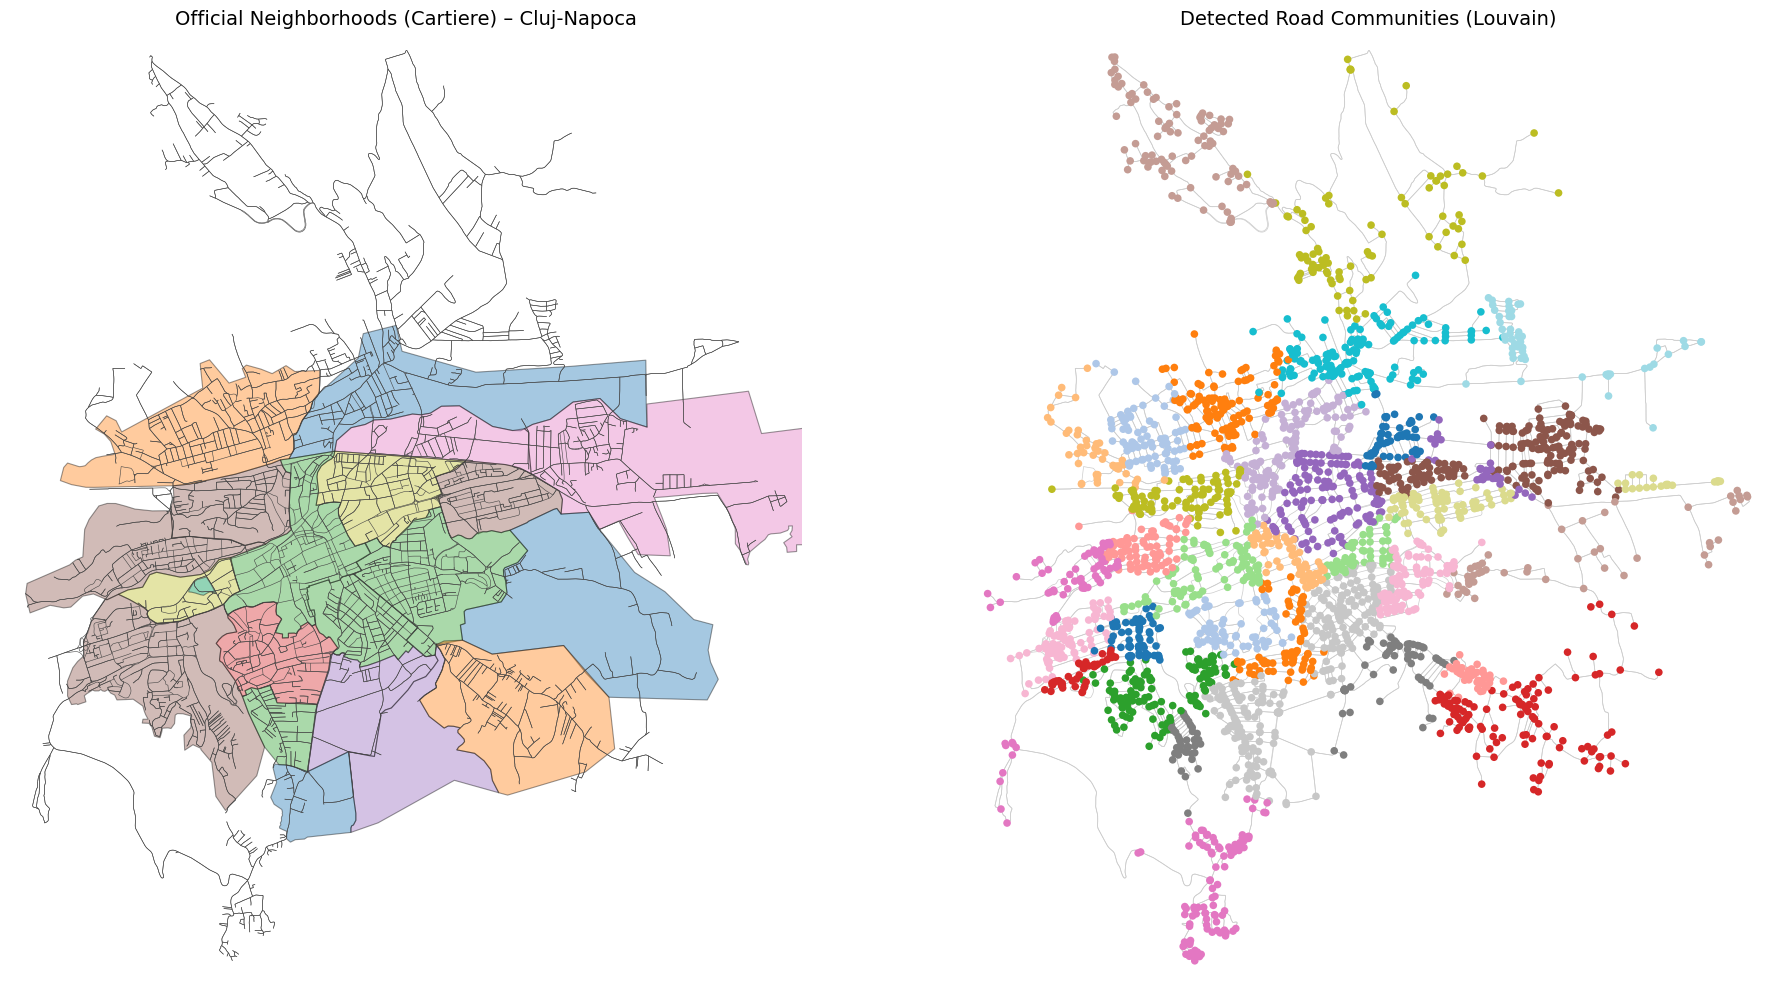

In [157]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

# --------------- ensure neighborhoods are ready ---------------
if gdf_neigh.empty:
    gdf_neigh = ox.features_from_place(
        "Cluj-Napoca, Romania",
        tags={"place": ["suburb", "neighbourhood"]}
    )
    print("Using point features instead of polygons")

# Random colors for real neighborhoods
unique_names = gdf_neigh["name"].dropna().unique()
color_map = {name: random.choice(list(mcolors.TABLEAU_COLORS.values())) for name in unique_names}
gdf_neigh["color"] = gdf_neigh["name"].map(color_map)

# --------------- Louvain community colors ---------------
cmap = plt.colormaps["tab20"]
node_color = [cmap(louvain_part[n] % 20) for n in G.nodes()]

# --------------- Draw side-by-side comparison ---------------
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Left: real neighborhoods
gdf_neigh.plot(ax=axs[0], color=gdf_neigh["color"], alpha=0.4, edgecolor="black", linewidth=0.8)
ox.plot_graph(
    G,
    ax=axs[0],
    node_size=0,
    edge_color="#444444",
    edge_linewidth=0.4,
    bgcolor="white",
    show=False,
    close=False,
)
axs[0].set_title("Official Neighborhoods (Cartiere) – Cluj-Napoca", fontsize=14)
axs[0].axis("off")

# Right: detected Louvain communities
ox.plot_graph(
    G,
    ax=axs[1],
    node_color=node_color,
    node_size=30,
    edge_color="#cccccc",
    edge_linewidth=0.5,
    bgcolor="white",
    show=False,
    close=False,
)
axs[1].set_title("Detected Road Communities (Louvain)", fontsize=14)
axs[1].axis("off")

plt.tight_layout()
plt.show()


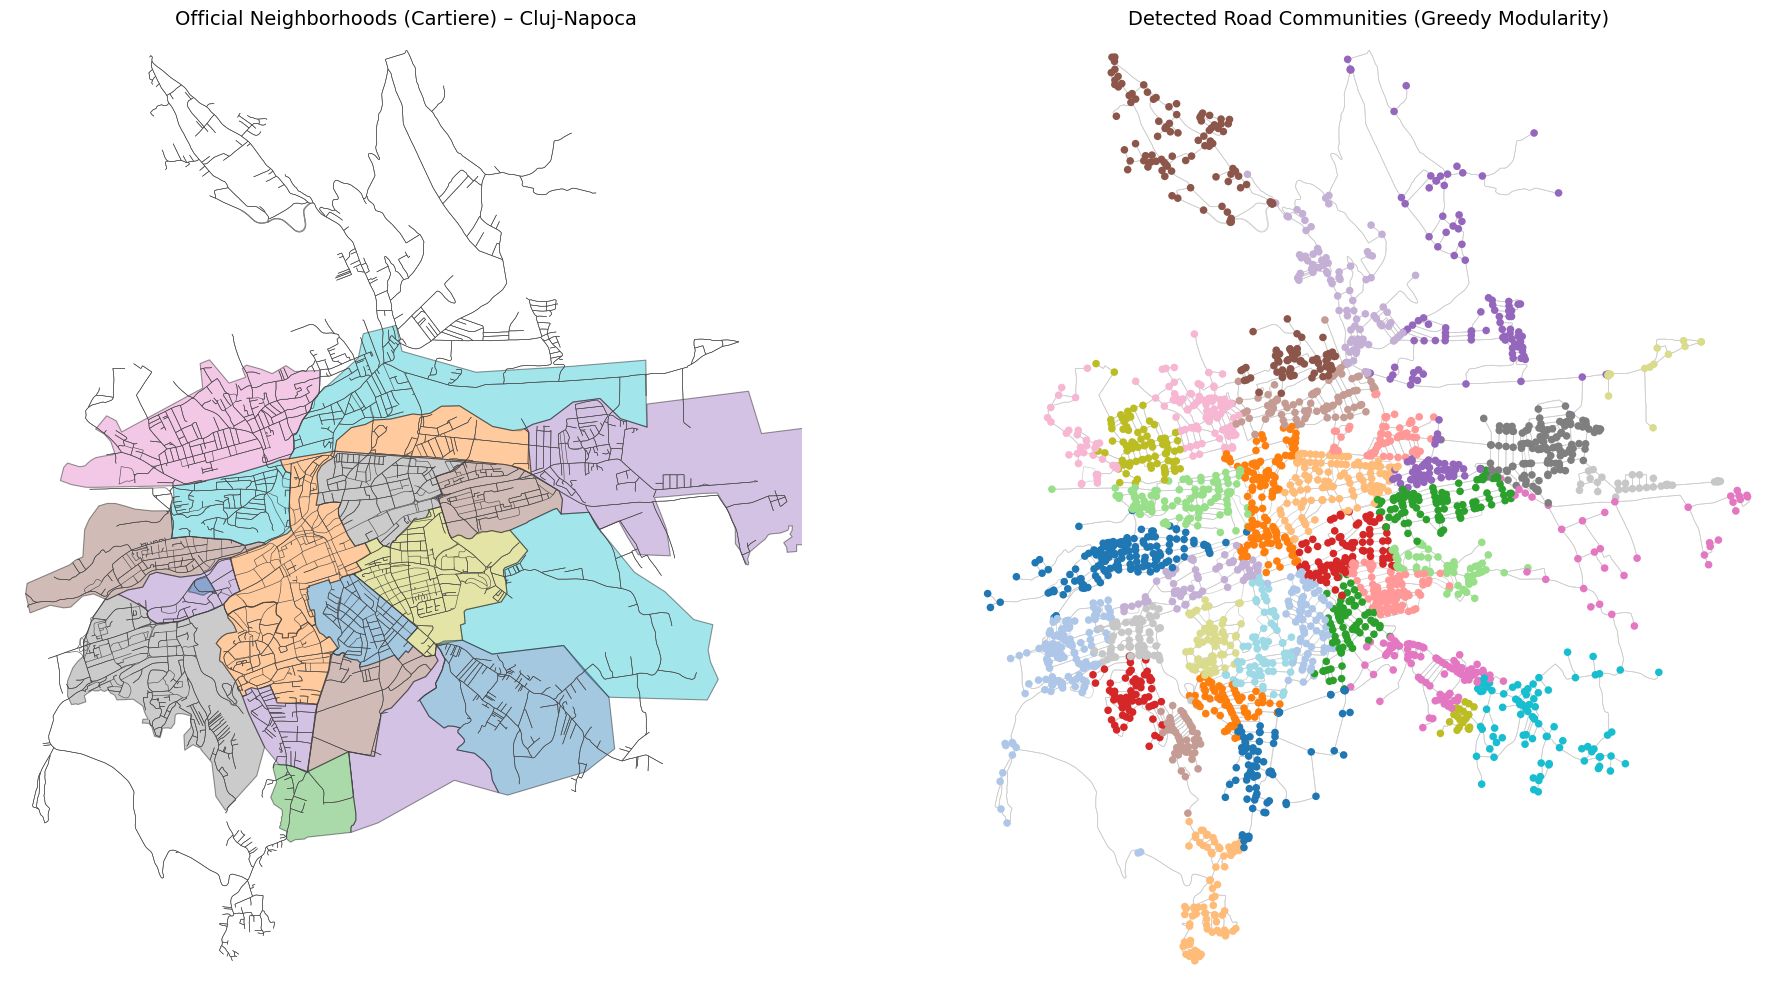

In [158]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

if 'gdf_neigh' not in locals() or gdf_neigh.empty:
    try:
        gdf_neigh = ox.features_from_place(
            "Cluj-Napoca, Romania",
            tags={"place": ["suburb", "neighbourhood"]}
        )
        # Filter only polygon boundaries if needed
        gdf_neigh = gdf_neigh[gdf_neigh.geometry.type.isin(["Polygon", "MultiPolygon"])]
        print("Downloaded neighborhood data.")
    except Exception as e:
        print(f"Could not download neighborhood data: {e}")
        print("Using point features instead of polygons if available from previous attempts.")
        # Fallback to using point features if polygons couldn't be downloaded
        if 'gdf_neigh' not in locals() or gdf_neigh.empty:
             # Attempt to get point features if polygons failed or were empty
             try:
                 gdf_neigh = ox.features_from_place(
                     "Cluj-Napoca, Romania",
                     tags={"place": ["suburb", "neighbourhood"]}
                 )
                 # Filter only point features
                 gdf_neigh = gdf_neigh[gdf_neigh.geometry.type.isin(["Point"])]
                 print("Downloaded neighborhood point data.")
             except Exception as e_points:
                  print(f"Could not download neighborhood point data: {e_points}")
                  print("Proceeding without neighborhood comparison plot.")
                  # If all attempts fail, skip the plotting part or handle gracefully


if 'gdf_neigh' in locals() and not gdf_neigh.empty:
    # Random colors for real neighborhoods
    unique_names = gdf_neigh["name"].dropna().unique()
    # Ensure unique_names is not empty before creating color_map
    if len(unique_names) > 0:
        color_map = {name: random.choice(list(mcolors.TABLEAU_COLORS.values())) for name in unique_names}
        gdf_neigh["color"] = gdf_neigh["name"].map(color_map)
    else:
        print("No names found for neighborhoods. Using a single color.")
        gdf_neigh["color"] = "lightblue"


    # --------------- Greedy Modularity community colors ---------------
    # Need to create a community map from the greedy communities (list of sets)
    community_map_greedy = {}
    # Assuming 'greedy' variable is available from cell FX9hn_sqoY18
    if 'greedy' in locals() and greedy:
        for i, c in enumerate(greedy):
            for node in c:
                community_map_greedy[node] = i

        cmap_greedy = plt.colormaps["tab20"] if len(greedy) > 10 else plt.colormaps["tab10"]
        # Ensure all nodes in G are in community_map_greedy before creating node_color_greedy
        # Nodes in G should correspond to nodes in the communities found by greedy algorithm
        node_color_greedy = [cmap_greedy(community_map_greedy.get(n, -1) % cmap_greedy.N) for n in G.nodes()] # Use .get(n, -1) to handle potential nodes not in community_map_greedy


        # --------------- Draw side-by-side comparison ---------------
        fig, axs = plt.subplots(1, 2, figsize=(20, 10))

        # Left: real neighborhoods
        # Check geometry type for plotting - plot polygons differently from points
        if gdf_neigh.geometry.iloc[0].geom_type in ["Polygon", "MultiPolygon"]:
             gdf_neigh.plot(ax=axs[0], color=gdf_neigh["color"], alpha=0.4, edgecolor="black", linewidth=0.8)
        elif gdf_neigh.geometry.iloc[0].geom_type == "Point":
             # Plot points if only point features were downloaded
             gdf_neigh.plot(ax=axs[0], color=gdf_neigh["color"], alpha=0.6, markersize=20) # Adjust markersize as needed
        else:
             print("Neighborhood data geometry type not supported for plotting.")
             # Handle unsupported geometry type


        ox.plot_graph(
            G, # Plot the graph on top of neighborhoods
            ax=axs[0],
            node_size=0,
            edge_color="#444444",
            edge_linewidth=0.4,
            bgcolor="none", # Use "none" for transparency to see neighborhoods
            show=False,
            close=False,
        )
        axs[0].set_title("Official Neighborhoods (Cartiere) – Cluj-Napoca", fontsize=14)
        axs[0].axis("off")

        # Right: detected Greedy Modularity communities
        # Plot the graph with nodes colored by Greedy Modularity communities
        ox.plot_graph(
            G, # Plot the original graph G
            ax=axs[1],
            node_color=node_color_greedy,
            node_size=30,
            edge_color="#cccccc",
            edge_linewidth=0.5,
            bgcolor="white",
            show=False,
            close=False,
        )
        axs[1].set_title("Detected Road Communities (Greedy Modularity)", fontsize=14)
        axs[1].axis("off")

        plt.tight_layout()
        plt.show()
    else:
        print("Greedy communities variable not found or is empty. Skipping Greedy Modularity comparison plot.")

else:
    print("Neighborhood data (gdf_neigh) is not available or is empty. Skipping comparison plot.")